# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations

from fim_doe import *
from pyomo.contrib.sensitivity_toolbox.sens import sipopt
from idaes.apps.uncertainty_propagation.sens import get_dsdp
#from pyomo.contrib.sensitivity_toolbox.sens import get_dsdp

    'pyomo.common.sorting.sorted_robust'.  Please update your import.
    (deprecated in 6.1) (called from <frozen importlib._bootstrap>:228)


## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_models import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [12]:
# choose model from 'dynamic-DAE', 'constant-DAE', 'constant-analytical'
model_opt = 'dynamic-DAE'
#model_opt = 'constant-DAE'
#model_opt = 'constant-analytical'

createmod = create_model_overall

if (model_opt=='dynamic-DAE'):
    args_ = [True, False, False]
    disc = discretizer
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
elif (model_opt=='constant-DAE'):
    args_ = [True, True, False]
    disc = discretizer
    t_control = [0]
    
elif (model_opt=='constant-analytical'):
    args_ = [False, True, False]
    disc = None
    t_control = [0]

    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [5]:
# empty prior
prior_all = np.zeros((4,4))


# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
#prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

prior_all = prior_5_300


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[  22.52943024    1.84034314  -70.23273336  -11.09432962]
 [   1.84034314   18.09848116   -5.73565034 -109.15866135]
 [ -70.23273336   -5.73565034  218.94192843   34.57680848]
 [ -11.09432962 -109.15866135   34.57680848  658.37644634]]
Prior Det: 1.8919381636034424e-08
Eigenvalue of the prior experiments FIM: [2.38378604e+02 6.79567681e+02 2.12450662e-07 5.49729273e-07]
Eigenvalue of the prior experiments FIM: [[-0.87143147  0.38380582  0.30437815 -0.02557787]
 [ 0.39764512  0.90284244 -0.01368273 -0.16299286]
 [-0.2795342   0.12312967 -0.94886453  0.07972337]
 [ 0.0659256   0.14969203  0.0826004   0.9830683 ]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [13]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
#sensi_opt = 'sequential_kaug'
#sensi_opt = 'direct_kaug'

if sensi_opt == 'direct_kaug':
    args_[2] = True
    

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [300])

print('Design variable:', exp1)

Design variable: {'CA0': {0: 5}, 'T': {0: 570.21, 0.125: 300, 0.25: 300, 0.375: 300, 0.5: 300, 0.625: 300, 0.75: 300, 0.875: 300, 1: 300}}


In [14]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)


if_s = True

result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                scale_nominal_param_value=if_s, formula='central')


if sensi_opt == 'simultaneous_finite':
    result.extract_FIM(doe_object.m, doe_object.design_timeset,
                                                          doe_object.square_result, doe_object.obj_opt)
else: 
    result.calculate_FIM(doe_object.jac, doe_object.design_values)


Sensitivity information is scaled by its corresponding parameter nominal value.
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resu

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following ackn

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following ackn

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following ackn

Build time with sequential_finite mode [s]: 0.030359983444213867
Solve time with sequential_finite mode [s]: 0.689023494720459
Existed information has been added.
FIM: [[ 444.73444486   60.16555026  -72.0389764  -709.54690683]
 [  60.16555026   33.90006296    8.59147417 -252.92817324]
 [ -72.0389764     8.59147417  278.77444283  -64.27418769]
 [-709.54690683 -252.92817324  -64.27418769 2108.61447957]]
Trace: 2866.023430223978
Determinant: 7436356.140962985
Condition number: 34474.36334812389
Minimal eigen value: 0.06958527991997998
Eigen values: [2.39890822e+03 3.33446806e+02 1.33598815e+02 6.95852799e-02]
Eigen vectors: [[ 0.34161842  0.49673667 -0.78580509  0.13805759]
 [ 0.10857518 -0.05915107  0.18121947  0.97563932]
 [ 0.01712901 -0.85110267 -0.5229036   0.04361949]
 [-0.93338892  0.15930498 -0.27611896  0.16481917]]


In [15]:
print(doe_object.jac)

{'A1': [0.0, -3.6606054667029047, -2.3635239079111026, -1.6150093116358288, -1.0903633700746014, -0.7260229165519549, -0.48266087544115777, -0.33421599778240446, -0.29551645276085936, 0.0, 0.2896180336036336, -0.7633655968353416, -1.3662693127746153, -1.835098699600124, -2.3060862988616426, -2.9903008443893375, -4.506776317240912, -11.571227909032684, 0.0, 3.3709874330992267, 3.1268895047464884, 2.981278624410444, 2.925462069674678, 3.032109215413592, 3.472961719830492, 4.840992315023285, 11.866744361793536], 'A2': [0.0, 0.2913907028615048, 0.22621018043024188, 0.15686416249269808, 0.10340170647900326, 0.06565638369605414, 0.04002712884921822, 0.022822113782026282, 0.009991438111041102, 0.0, -0.5173616100142109, -0.7401246889483959, -0.9436940316240205, -1.1075576934014952, -1.21552642763052, -1.2561526639995213, -1.2117065264168558, -1.007508459687373, 0.0, 0.2259709071527116, 0.5139145085181318, 0.7868298691313447, 1.0041559869225392, 1.1498700439344756, 1.216125535150292, 1.18888441

In [16]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 3.4572797365063326
D-optimality: 6.871360180770548
E-optimality: -1.1574826213901612
Modified E-optimality: 4.5374962546317965


### Run sequential DOE automatically

This method runs a series of experiments in a row.

In [ ]:
# this only works for constant T mode. 
exp1 = generate_exp(t_control, 5, [300])
exp2 = generate_exp(t_control, 5, [500.92])
exp3 = generate_exp(t_control, 5, [528])
exp4 = generate_exp(t_control, 5, [546.8])
exp5 = generate_exp(t_control, 5, [562])

In [ ]:

exp_all = [exp1, exp2, exp3, exp4, exp5]


doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sequential_exp(exp_all, mode=sensi_opt, tee_option=True,
                                    scale_nominal_param_value=if_s, formula='central')

In [ ]:
print('=======Result summary=======')
for i in range(len(exp_all)):
    print('The ', i+1,'th experiment has optimality log10() values:')
    print('A-optimality:', np.log10(result[0][i].trace))
    print('D-optimality:', np.log10(result[0][i].det))
    print('E-optimality:', np.log10(result[0][i].min_eig))
    print('Modified E-optimality:', np.log10(result[0][i].cond))

## Optimization

In [18]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc, args=args_)

square_result, optimize_result = doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=None)


Sensitivity information is scaled by its corresponding parameter nominal value.
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False


ValueError: The NL writer has detected multiple active objective functions on model unknown, but currently only handles a single objective.

In [ ]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('It gives solution:', optimize_result.solution)
print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(value(optimize_result.model.T[i]))

si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
    
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

## Grid search for 2 design variables

In [19]:
design_ranges = [list(np.linspace(1,5,9)), list(np.linspace(300,700,9))]

dv_apply_name = ['CA0','T']

dv_apply_time = [[0],t_control]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])
    
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
#sensi_opt = 'sequential_kaug'
#sensi_opt = 'direct_kaug'

if sensi_opt == 'direct_kaug':
    args_[2] = True

In [21]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt, 
                                    scale_nominal_param_value=True
                                    )

81  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300.0, 0.25: 300.0, 0.375: 300.0, 0.5: 300.0, 0.625: 300.0, 0.75: 300.0, 0.875: 300.0, 1: 300.0}}
Sensitivity information is scaled by its corresponding parameter nominal value.
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.031255245208740234
Solve time 

Build time with sequential_finite mode [s]: 0.03173398971557617
Solve time with sequential_finite mode [s]: 0.7128989696502686
Existed information has been added.
FIM: [[  22.85778568    1.58806577  -71.06150457   -9.85321782]
 [   1.58806577   18.80410201   -5.286094   -112.67643949]
 [ -71.06150457   -5.286094    221.10525335   32.37888468]
 [  -9.85321782 -112.67643949   32.37888468  675.93331915]]
Trace: 938.7004601958402
Determinant: 7.262664127105343
Condition number: 587380.8056164271
Minimal eigen value: 0.001187152066583163
Eigen values: [6.97310337e+02 2.41352585e+02 1.18715207e-03 3.63505971e-02]
Eigen vectors: [[ 0.02234475  0.30528812 -0.70708024 -0.63744601]
 [ 0.16395232 -0.01289453 -0.66068357  0.73242787]
 [-0.07203153 -0.94926903 -0.22700141 -0.20535366]
 [-0.98358111  0.0743048  -0.10956786  0.12264531]]
This is the  5  run out of  81 run.
The code has run 5.9352 seconds.
Estimated remaining time: 90.2145 seconds
=======This is the  6 th iteration=======
Design varia

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.030852556228637695
Solve time with sequential_finite mode [s]: 0.7187416553497314
Existed information has been added.
FIM: [[  23.36699479    1.15109824  -72.31327058   -7.14789892]
 [   1.15109824   19.51581166   -4.44570537 -115.94368617]
 [ -72.31327058   -4.44570537  224.32831285   26.54325739]
 [  -7.14789892 -115.94368617   26.54325739  692.77427462]]
Trace: 959.985393919721
Determinant: 591.711692524396
Condition number: 27770.09482

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.03090643882751465
Solve time with sequential_finite mode [s]: 0.7253015041351318
Existed information has been added.
FIM: [[  23.22197459    1.31949866  -72.00914529   -8.60641573]
 [   1.31949866   19.70508356   -4.83212402 -117.01118033]
 [ -72.00914529   -4.83212402  223.65716167   30.31650933]
 [  -8.60641573 -117.01118033   30.31650933  696.78486895]]
Trace: 963.3690887765521
Determinant: 27.833081449419428
Condition number: 381758.10

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.0327761173248291
Solve time with sequential_finite mode [s]: 0.7494149208068848
Existed information has been added.
FIM: [[ 2.39888360e+01  6.44891388e-01 -7.38665977e+01 -4.95564433e+00]
 [ 6.44891388e-01  2.06696983e+01 -3.51318135e+00 -1.22545072e+02]
 [-7.38665977e+01 -3.51318135e+00  2.28361919e+02  2.32310415e+01]
 [-4.95564433e+00 -1.22545072e+02  2.32310415e+01  7.28174375e+02]]
Trace: 1001.1948282731413
Determinant: 46.74517178466

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.029809236526489258
Solve time with sequential_finite mode [s]: 0.7275562286376953
Existed information has been added.
FIM: [[  23.7453982     1.01697638  -73.33455715   -7.28518116]
 [   1.01697638   21.06945633   -4.3522319  -123.06353225]
 [ -73.33455715   -4.3522319   227.07791215   28.21494145]
 [  -7.28518116 -123.06353225   28.21494145  723.5210959 ]]
Trace: 995.4138625773894
Determinant: 296.90945166894204
Condition number: 82028.58

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.032620906829833984
Solve time with sequential_finite mode [s]: 0.7267110347747803
Existed information has been added.
FIM: [[ 2.46712626e+01  7.25863326e-02 -7.55371293e+01 -1.52581788e+00]
 [ 7.25863326e-02  2.22333673e+01 -2.53474131e+00 -1.31208851e+02]
 [-7.55371293e+01 -2.53474131e+00  2.32622185e+02  1.71069454e+01]
 [-1.52581788e+00 -1.31208851e+02  1.71069454e+01  7.76018820e+02]]
Trace: 1055.5456349034139
Determinant: 195.54239366

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.0310821533203125
Solve time with sequential_finite mode [s]: 0.7441203594207764
Existed information has been added.
FIM: [[ 2.43682533e+01  7.08134996e-01 -7.52801445e+01 -6.04109673e+00]
 [ 7.08134996e-01  2.28081214e+01 -4.79195860e+00 -1.30377899e+02]
 [-7.52801445e+01 -4.79195860e+00  2.34178488e+02  3.03360117e+01]
 [-6.04109673e+00 -1.30377899e+02  3.03360117e+01  7.54080640e+02]]
Trace: 1035.4355027698957
Determinant: 621.2064660113

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.029917240142822266
Solve time with sequential_finite mode [s]: 0.6798861026763916
Existed information has been added.
FIM: [[ 2.56024917e+01 -6.26486593e-03 -7.81243081e+01 -1.71217931e+00]
 [-6.26486593e-03  2.47881852e+01 -2.24701876e+00 -1.40799043e+02]
 [-7.81243081e+01 -2.24701876e+00  2.39530845e+02  1.63370282e+01]
 [-1.71217931e+00 -1.40799043e+02  1.63370282e+01  8.08539287e+02]]
Trace: 1098.4608085889647
Determinant: 3165.9087707

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.03305625915527344
Solve time with sequential_finite mode [s]: 0.8216719627380371
Existed information has been added.
FIM: [[ 2.51058391e+01  4.28877461e-01 -7.68560528e+01 -5.02180984e+00]
 [ 4.28877461e-01  2.49224231e+01 -3.59147134e+00 -1.38685801e+02]
 [-7.68560528e+01 -3.59147134e+00  2.36352927e+02  2.53766406e+01]
 [-5.02180984e+00 -1.38685801e+02  2.53766406e+01  7.86286510e+02]]
Trace: 1072.6676988182517
Determinant: 3266.13067060

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.031647682189941406
Solve time with sequential_finite mode [s]: 0.8299469947814941
Existed information has been added.
FIM: [[ 2.64353032e+01 -1.13174151e+00 -8.01383390e+01  3.63161039e+00]
 [-1.13174151e+00  2.69630126e+01 -4.87088294e-01 -1.53636048e+02]
 [-8.01383390e+01 -4.87088294e-01  2.44894908e+02  8.74510817e+00]
 [ 3.63161039e+00 -1.53636048e+02  8.74510817e+00  8.81673633e+02]]
Trace: 1179.9668564281294
Determinant: 1102.9313721

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.03721785545349121
Solve time with sequential_finite mode [s]: 0.9534194469451904
Existed information has been added.
FIM: [[  29.60378301   -3.64880935  -82.1205141    17.3821499 ]
 [  -3.64880935   28.25082569   -1.65304953 -162.38464167]
 [ -82.1205141    -1.65304953  246.59009731   13.00673328]
 [  17.3821499  -162.38464167   13.00673328  937.74651949]]
Trace: 1242.1912254944034
Determinant: 8235.25358683877
Condition number: 52178.7232

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.02926039695739746
Solve time with sequential_finite mode [s]: 0.7534558773040771
Existed information has been added.
FIM: [[ 2.60170105e+01  4.66132728e-02 -7.99753127e+01 -6.02253866e+00]
 [ 4.66132728e-02  2.91524180e+01  1.41948537e+00 -1.64580611e+02]
 [-7.99753127e+01  1.41948537e+00  2.49937133e+02  9.98684470e+00]
 [-6.02253866e+00 -1.64580611e+02  9.98684470e+00  9.43462800e+02]]
Trace: 1248.5693621038638
Determinant: 39629.3155658

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.02795577049255371
Solve time with sequential_finite mode [s]: 0.6942675113677979
Existed information has been added.
FIM: [[  30.17272223   -4.18884081  -89.1044638    19.88663874]
 [  -4.18884081   31.08718816    5.16470204 -176.88847127]
 [ -89.1044638     5.16470204  267.57625841  -21.10479652]
 [  19.88663874 -176.88847127  -21.10479652 1012.05397319]]
Trace: 1340.890141983125
Determinant: 1321.4261148300932
Condition number: 109894.64

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.02761530876159668
Solve time with sequential_finite mode [s]: 0.6862764358520508
Existed information has been added.
FIM: [[ 2.83976041e+01 -1.67609377e+00 -8.54361913e+01  5.27933611e+00]
 [-1.67609377e+00  3.33874465e+01  1.73718404e-02 -1.80550094e+02]
 [-8.54361913e+01  1.73718404e-02  2.59251869e+02  7.88570633e+00]
 [ 5.27933611e+00 -1.80550094e+02  7.88570633e+00  9.92110458e+02]]
Trace: 1313.147377519939
Determinant: 9737.395772584

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.027086973190307617
Solve time with sequential_finite mode [s]: 0.6586818695068359
Existed information has been added.
FIM: [[  31.43030815   -5.33439747  -92.48550645   25.11853827]
 [  -5.33439747   34.61961863    7.43268078 -194.41474548]
 [ -92.48550645    7.43268078  276.77939762  -31.1945572 ]
 [  25.11853827 -194.41474548  -31.1945572  1099.06905538]]
Trace: 1441.8983797824621
Determinant: 1983.6758411296003
Condition number: 97908.9

Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Pyomo.DAE option: True
Constant T option: False
K_aug formulation: False
Build time with sequential_finite mode [s]: 0.028540611267089844
Solve time with sequential_finite mode [s]: 0.6787211894989014
Existed information has been added.
FIM: [[  29.88472223   -2.68849472  -89.07748234    9.11862585]
 [  -2.68849472   36.9370456     1.54848509 -194.03562837]
 [ -89.07748234    1.54848509  268.44630988    2.22990802]
 [   9.11862585 -194.03562837    2.22990802 1041.19328846]]
Trace: 1376.4613661707033
Determinant: 17886.083553769175
Condition number: 17044.0

### 1D sensitivity curve

Design variable:  ['CA0', 'T']
Value          :  (1.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 350.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 450.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 550.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 650.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 350.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 450.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 550.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 600.0)
Design v

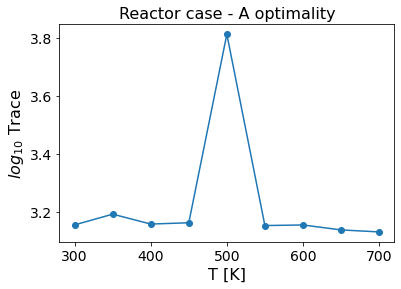

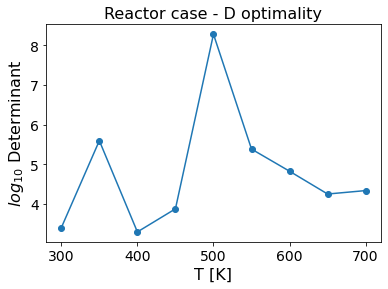

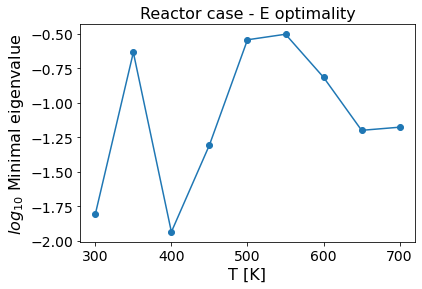

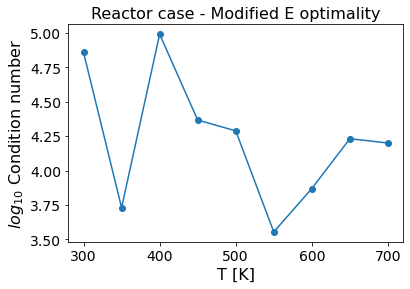

In [22]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

2D heatmap is plotted with  ['CA0', 'T'] .


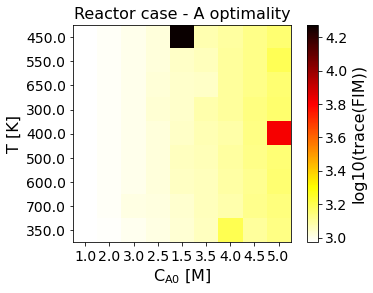

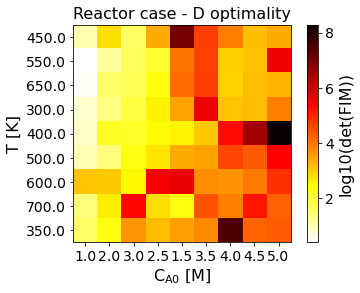

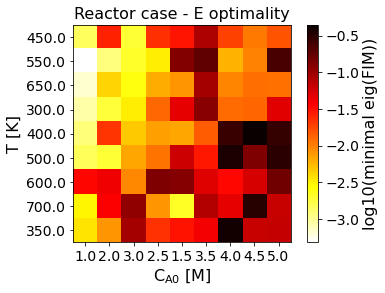

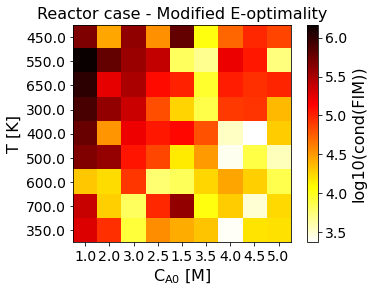

In [23]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:

#design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Dynamic heatmap

In [ ]:
design_ranges = [list(np.linspace(300,700,18))]

dv_apply_name = ['T']

count = 0
for ct in t_control:
    print('Time controlled:', ct)
    dv_apply_time = [[ct]]

    # Define experiments
    exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
    
    doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

    all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True,
                                     filename = '300base_'+str(count)+'.csv'
                                    )
    
    test = all_fim.extract_criteria()

    ## draw 1D sensitivity curve 

    fixed = {}

    all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )
    count += 1 

In [ ]:
filename_list = []
count = 0
for ct in t_control:
    print('Time controlled:', ct)
    filename_list.append('300base_'+str(count)+'.csv')
    count += 1
    
print(filename_list)

data_list = []
for i in filename_list:
    data_list.append(pd.read_csv(i))
print(np.shape(data_list))

In [ ]:
print(data_list[3]['D'].iloc[4])

In [ ]:
d_result = np.zeros((18,8))

for i in range(8):
    for j in range(18):
        d_result[j,i] = np.log10(data_list[i]['A'].iloc[j])
        
print(d_result)

In [ ]:
x_range1 = [0.125,0.25,0.375,0.5,0.625,0.75,0.875,1]
#x_range1 = [0.13, 0.25,0.38,0.5,0.63,0.75,0.88,1]
#x_range1 = [7.5, 15, 22.5, 30, 37.5, 45, 52.5, 60]
y_range1 = yLabel = [300, 321, 342, 363, 384, 405, 426, 447, 468, 489, 511, 532, 553, 574, 595, 616, 637, 658, 679, 700.0]

heatmap(x_range1, y_range1, 'Time [$min$]', 'Temperature [$K$]')

In [ ]:
import matplotlib.ticker as ticker
def heatmap(x_range, y_range, xlabel_text, ylabel_text, font_axes=16, font_tick=12, log_scale=True):
    '''
    Draw 2D heatmaps for all design criteria

    Parameters:
    ----------
    title_text: name of the figure, a string
    xlabel_text: x label title, a string.
        In a 2D heatmap, it should be the second design varialbe in the design_ranges
    ylabel_text: y label title, a string.
        In a 2D heatmap, it should be the first design variable in the dv_ranges
    font_axes: axes label font size
    font_tick: tick label font size
    log_scale: if True, the result matrix will be scaled by log10

    Returns:
    --------
    4 Figures of 2D heatmap for each criteria
    '''
    # set heatmap x,y ranges
    xLabel = x_range
    yLabel = y_range

    # D-optimality
    fig = plt.figure()
    plt.rc('axes', titlesize=font_axes)
    plt.rc('axes', labelsize=font_axes)
    plt.rc('xtick', labelsize=font_tick)
    plt.rc('ytick', labelsize=font_tick)
    ax = fig.add_subplot(111)
    params = {'mathtext.default': 'regular'}
    plt.rcParams.update(params)
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    ax.set_ylabel(ylabel_text)
    
    
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    loc = ticker.MultipleLocator(base=3)
    ax.xaxis.set_major_locator(loc)
    ax.set_xlabel(xlabel_text)

    im = ax.imshow(d_result, cmap=plt.cm.hot_r)
    ba = plt.colorbar(im)
    ba.set_label('$log_{10}$(A-optimality)',labelpad=-40, y=1.1, rotation=0)
    plt.show()
